## Customer Churn Prediction

In [1]:
# Importing packages
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, roc_auc_score, auc
from sklearn.metrics import confusion_matrix
import numpy as np
import matplotlib.pyplot as plt

#### Defining Churn for analysis
Churn: (no interaction in the last 20 days) through T/F -> 1/0


In [2]:
# load the dataset
data = pd.read_csv('data/user/user_data.csv')

# convert 'last_played' to datetime and create days since last played
data['last_played'] = pd.to_datetime(data['last_played'])
data['days_since_last_played'] = (pd.to_datetime('now') - data['last_played']).dt.days

# determine churn, per user NOT per row
user_last_played = data.groupby('user_id')['days_since_last_played'].max().reset_index() # Create a df showing closest streaming date per user
user_last_played['churn'] = user_last_played['days_since_last_played'] > 20 # Define churn

# Add randomness to the churn, adding variability to mimic reality
np.random.seed(42)  # reproducibility
flip_prob = 0.20  # Probability churn changing
random_flips = np.random.rand(len(user_last_played)) < flip_prob
user_last_played['churn'] = user_last_played['churn'] ^ random_flips

# merge the churn information back into the original dataset
data = data.merge(user_last_played[['user_id', 'churn']], on='user_id', how='left')

# convert churn from T/F to 1/0
data['churn'] = data['churn'].astype(int)

data.to_csv("data/user/user_churn.csv", index=False)
data.head(10)

,user_id,song_id,play_count,last_played,user_age,user_country,days_since_last_played,churn
0,india_user_0,00Srvq2BtgG9afXY9kzB1V,27,2024-03-29 11:25:10.912694,20,india,66,0
1,india_user_0,01N3UDXUKUP6e2It26WAak,5,2024-05-14 11:25:10.912733,20,india,20,0
2,india_user_0,09CnYHiZ5jGT1wr1TXJ9Zt,6,2024-05-29 11:25:10.912735,20,india,5,0
3,india_user_0,0ClPIeT6MSgfSgQ9ZrJbAq,1,2024-04-27 11:25:10.912737,20,india,37,0
4,india_user_0,0CnlKa2jjIMzG0gLN1KZbD,14,2024-03-12 11:25:10.912738,20,india,83,0
5,india_user_0,0HGItm7Ox9AnHZbx26nkE4,12,2024-05-31 11:25:10.912739,20,india,3,0
6,india_user_0,0Jx0wecBc4647J4QMdmsY1,4,2024-03-25 11:25:10.912740,20,india,70,0
7,india_user_0,0LMwmV37RCmBO2so0szAFs,8,2024-03-29 11:25:10.912741,20,india,66,0
8,india_user_0,0M0ANKNzmM4Odd7FNKghzW,48,2024-04-09 11:25:10.912742,20,india,55,0
9,india_user_0,0TL0LFcwIBF5eX7arDIKxY,12,2024-03-18 11:25:10.912743,20,india,77,0


In [3]:
# Group by 'user_id' and take the maximum 'churn' value per user
user_churn = data.groupby('user_id')['churn'].max().reset_index()

# Count the number of users with churn = 0 and churn = 1
churn_counts = user_churn['churn'].value_counts()

print(churn_counts)


churn
1    775
0    225
Name: count, dtype: int64


In [4]:
# Define features and target
features = ['user_age', 'play_count']
target = 'churn'

X = data[features]
y = data[target]

In [5]:
# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [6]:
# Hyperparameter Tuning using GridSearchCV
param_grid = {
    'n_estimators': [50,100],
    'max_depth': [5,10],
    'min_samples_split': [10,15],
    'min_samples_leaf': [4,6],
    'bootstrap': [True]
}

rf = RandomForestClassifier(random_state=42)
grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=3, n_jobs=-1, verbose=0, scoring='roc_auc')
grid_search.fit(X_train, y_train)

# Best model from GridSearch
best_rf = grid_search.best_estimator_
print(f'Best parameters found: {grid_search.best_params_}')

Best parameters found: {'bootstrap': True, 'max_depth': 10, 'min_samples_leaf': 6, 'min_samples_split': 10, 'n_estimators': 100}


In [7]:
# Predict and evaluate
y_pred = best_rf.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print(f'Accuracy: {accuracy:.4f}')
print(f'Precision: {precision:.5f}')
print(f'Recall: {recall:.5f}')
print(f'F1 Score: {f1:.5f}')
print(f'Confusion Matrix: \n {confusion_matrix(y_test, y_pred)}')

Accuracy: 0.7733
Precision: 0.77349
Recall: 0.99966
F1 Score: 0.87215
Confusion Matrix: 
 [[    4  9571]
 [   11 32684]]


### Visualising the model

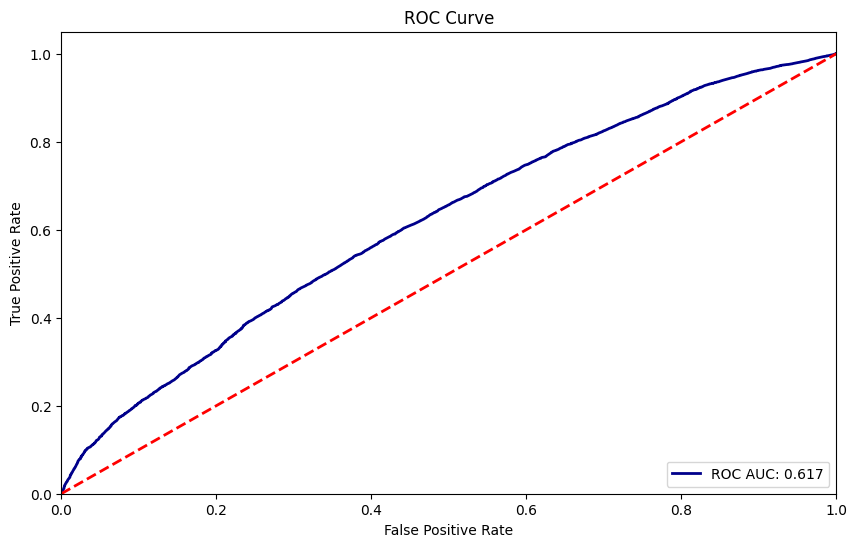

In [8]:
# Make predictions
y_pred_proba = best_rf.predict_proba(X_test)[:, 1]

# Calculate ROC curve and AUC
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure(figsize=(10, 6)) # making the figure larger
plt.plot(fpr, tpr, color='darkblue', lw=2, label=f'ROC AUC: {roc_auc:.3f}')
plt.plot([0, 1], [0, 1], color='red', lw=2, linestyle='--') # diagonal line for ref
plt.xlim([0.0, 1.0]) # correct limits
plt.ylim([0.0, 1.05]) # limits + extra for visual aid
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.savefig('figures/churn_roc')
plt.show()

In [9]:
# Save the model
import joblib
joblib.dump(best_rf, 'models/churn_prediction_model.pkl')

['models/churn_prediction_model.pkl']